# 1. Project Overview

This project looks at forcasting conversion to Alzheimer's Disease (AD) from mild cognitive impairment (MCI) using data from the Alzheimer's Disease Neuroimaging Initiative (ADNI). The dataset being used contains seven different categories of data.

* Demographic information. This includes a patient's baseline diagnosis, age, gender, level of education, ethnicity, and marital status.

* Cognitive assessments. These are summary scores on the following tests: Clinical Dementia Rating Scale Sum of Box (CDRSB), Alzheimer's Disease Assessment Scale 13 (ADAS13), Mini Mental State Examination (MMSE), and the Montreal Cognitive Assessment (MoCA).

* Electroencephalography (Ecog) measurements during a memory task and a visuospatial task.

* Magnetic resonance imaging (MRI). These data are based on structural MRI, functional MRI, and diffusion tensor imaginge. Structural MRI data includes volumetric measures of the left and right hippocampus, and the left and right entorhinal cortex. Functional MRI data include anterior (aDMN) and posterior (pDMN) default mode network functional connectivity expressed as average z-scores for inter-voxel correlations, as well as a ratio of anterior vs posterior default mode network functional connectivity. Diffusion tensor imaging data are fractional anisotropy and mean diffusivity values for the left and right hippocampus.

* Positron emission tomography (PET). These data include measures of cell metabolism (and therefore neurodegeneration) using Fluorodeoxyglucose (FDG) across distributed brain regions as well as the hippocampus, levels of amyloid-beta protiens (AV45) and levels of abnormal phosphorylated tau proteins (AV1451) within the left and right hippocampus and the left and right entorhinal cortex.

* Genetic. Alipoprotein E4 variant (APOE4) is a gene that is the largest known risk factor for AD.



# 2. Data Cleaning

Prior to doing some exploratory data analysis, the data needs to be reconfigured by renaming the columns of interest, extracting the relevant data points, and merging the main and fMRI dataframes. Missing values will then be assessed and a strategy for dealing with then be developed.

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
# this contains a dictonary of columns to rename and a metadata dictionary to organize the data into categories
import vector_dict

%matplotlib inline

In [2]:
# list of the measures that will be dropped from analyses
measures_to_drop = []
# list of measures to drop NaN values from
remove_nan = []
# list of the different visit types
visit_type = ['bl', 'm03', 'm06', 'm12', 'm18', 'm24', 'm30', 'm36', 'm42', 'm48', 'm54',
              'm60', 'm66', 'm72', 'm78', 'm84', 'm90', 'm96', 'm102', 'm108', 'm114', 'm120']
# dictionary to store visit types with all missing values
no_data_dict = {}

In [3]:
# method to display unique values for each data category
def unique_values(key):
    """
    This method returns an output of all the unique values for a column in a dataframe and will be used
    to identify how missing data is coded for each measurement type."""
    # loop through categories
    for data in vector_dict.metadata[key]:
        # display unique values for each data category
        print(f"Data category {data}:\ntest {df[data].unique()}")

# method to return table of NaN counts
def nan_count(measurement_type, single_measure=False):
    """
    This method returns a dataframe that identifies the number of NaN entries for measurements at different
    visit types and the percentage of NaNs for each visit type. If all entries are NaN, they are omitted 
    from the dataframe and identified as having no measurements for that visit. It also includes a parameter
    for single value measures rather than taking a list of different measurement types.
    """
    # list of single measure or measures for measurement type
    if single_measure:
        measure_list = [measurement_type]
    else:
        measure_list = list(vector_dict.metadata[measurement_type])
    # initiate dataframe
    df_nan = pd.DataFrame(columns=measure_list)
    # list of visit periods where data was not collected
    no_data_visit = []
    # loop through visit types
    for visit in visit_type:
        # extract data for each visit type
        dataframe = df[df.VISCODE == visit]
        # loop through different measures
        for measure in measure_list:
            # fill in
            # sum NaN values per measure
            nan_count = dataframe[measure].isnull().sum()
            df_nan.loc[f'{visit}_NaN_count', measure] = nan_count
            # calculate percentage of NaN in column rounded to one decimal
            df_nan.loc[f'{visit}_percent_of_col', measure] = np.round(nan_count/len(dataframe[measure])*100,1)
        ### this moves visits with all missing data out of the dataframe
        # non baseline measurements
        non_baseline_df = df_nan.filter(items=[measure for measure in measure_list if 'bl' not in measure])
        # check to see if all measurements are NaN for visit
        if non_baseline_df.loc[f'{visit}_percent_of_col',:].sum() == 100*len(non_baseline_df.columns):
            # if all missing, move visit to no data list
            df_nan = df_nan.drop([f'{visit}_NaN_count', f'{visit}_percent_of_col'])
            no_data_visit.append(visit)
    # add visits with no data measurements to no data dict
    no_data_dict[measurement_type] = no_data_visit
    # print out the visits with no data measurements
    print(f'The visits that have no recorded data are {no_data_visit}.')
    # return the dataframe with NaN counts
    return df_nan

In [4]:
# Read in main data to a dataframe. This contains all but the fMRI dataset.
data = pd.read_csv('data/D1_D2.csv', dtype=object)
# print shape of dataframe
print(data.shape)

(12741, 1907)


As we can see, this is a large dataframe that includes many columns that are not needed for the analysis. The first step will be to rename and extract the columns of interest. These have been coded in a file called vector_dict.py. The columns represent potential features to use in a machine learning model to forcast conversion to AD and are based on measures that have previously been shown to be affected by the neurodegeneration that occurs in individuals with AD.

In [5]:
# rename columns
data.rename(columns=vector_dict.columns_to_rename, inplace=True)

In [6]:
# store all columns of interest
col_all = []
for k,v in vector_dict.metadata.items():
    # skip fMRI data as it needs to be merged from a separate file
    if k != 'fMRI':
        for item in v:
            col_all.append(item)

In [7]:
# extract demographic information
df = data[col_all].copy()
# display column names of new dataframe
print(df.columns)

Index(['RID', 'VISCODE', 'D1', 'D2', 'DX_bl', 'DXCHANGE', 'AGE', 'PTGENDER',
       'PTEDUCAT', 'PTETHCAT', 'PTMARRY', 'CDRSB_bl', 'CDRSB', 'ADAS13_bl',
       'ADAS13', 'MMSE_bl', 'MMSE', 'MOCA_bl', 'MOCA', 'EcogPtMem_bl',
       'EcogPtMem', 'EcogPtVisspat_bl', 'EcogPtVisspat', 'Ventricles_bl',
       'WholeBrain_bl', 'ICV_bl', 'l_hippocampus_l', 'l_hippocampus_r',
       'x_hippocampus_l', 'x_hippocampus_r', 'l_entorhinal_l',
       'l_entorhinal_r', 'l_entorhinal_l_thick', 'l_entorhinal_r_thick',
       'x_entorhinal_l', 'x_entorhinal_r', 'x_entorhinal_l_thick',
       'x_entorhinal_r_thick', 'FDG', 'FDG_bl', 'fdg_hippocampus', 'PIB',
       'PIB_bl', 'AV45', 'AV45_bl', 'av45_hippocampus_l', 'av45_hippocampus_r',
       'av45_entorhinal_l', 'av45_entorhinal_r', 'av1451_hippocampus_l',
       'av1451_hippocampus_r', 'av1451_entorhinal_l', 'av1451_entorhinal_r',
       'fa_hippocampus_l', 'fa_hippocampus_r', 'md_hippocampus_l',
       'md_hippocampus_r', 'APOE4'],
      dtype='object

Now that all the columns of interest from the main dataframe are extracted, the next step is to combine it with the fMRI data.

In [8]:
# read dataframe
df_fmri = pd.read_csv('data/resting_fmri.csv')
# display head
print(df_fmri.columns)

Index(['RID', 'VISCODE', 'VISCODE2', 'SCANDATE', 'VERSION', 'RUNDATE',
       'IMAGEUID', 'STATUS', 'ADMNRV', 'PDMNRV', 'DMNRVR', 'MAGSTRENG',
       'SERDESC', 'PITCH', 'ROLL', 'YAW', 'MMX', 'MMY', 'MMZ', 'SLICEORD',
       'COVVERMIS', 'COVCEREBEL', 'COVOCCIP', 'COVSUPER', 'COVTEMPOR',
       'COVOTHER', 'MEANTSNR', 'MEDTSNR', 'SDTSNR', 'PENCIL', 'VENETIAN',
       'PHASEDIR', 'update_stamp'],
      dtype='object')


For this dataframe, we want to match based on the participant ID (RID)and on the visit code (VISCODE for df and VISCODE2 for df_fmri) and extract the ADMNRV, PDMNRV, and DMNRVR columns.

In [9]:
# check datatype for column to join on
print(type(df.RID[0]), type(df_fmri.RID[0]))

<class 'str'> <class 'numpy.int64'>


This shows that the RID column in the main dataframe is coded as strings. This will be changed to integer before merging.

In [10]:
# convert RID column to integer
df.RID = pd.to_numeric(df.RID)
# display new column types
print(type(df.RID[0]), type(df_fmri.RID[0]))

<class 'numpy.int64'> <class 'numpy.int64'>


Now that they are the same data type, the Visit code column on the fMRI dataframe needs to be renamed.

In [11]:
# first drop the VISCODE column on df_fmri
df_fmri.drop(columns='VISCODE', inplace=True)
# rename VISCODE2 column to match df
df_fmri.rename(columns={'VISCODE2':'VISCODE'}, inplace=True)

In [12]:
# check to see the column categories match
print('df:', df.VISCODE.unique(), '\ndf_fmri:', df_fmri.VISCODE.unique())

df: ['bl' 'm06' 'm12' 'm24' 'm18' 'm36' 'm72' 'm84' 'm48' 'm60' 'm96' 'm03'
 'm90' 'm66' 'm78' 'm30' 'm42' 'm54' 'm102' 'm108' 'm120' 'm114'] 
df_fmri: ['m120' 'm96' 'm72' 'm60' 'm84' 'm108' 'm48' 'm06' 'scmri' 'm12' 'm24'
 'm36' 'm03' nan]


From the output, it appears that the baseline measurements are coded different in each dataframe. df_fmri will be updated to use the bl code for baseline.

In [13]:
# replace scmri with bl
df_fmri.VISCODE.replace({'scmri':'bl'}, inplace=True)

In [14]:
# extract columns of interest
# columns of interest
col_fmri = ['RID', 'VISCODE', 'ADMNRV', 'PDMNRV', 'DMNRVR']
df_fmri = df_fmri[col_fmri]

In [15]:
# merge dataframes
df = df.merge(df_fmri, on=['RID', 'VISCODE'], how='left')
# check merge
print(df.columns)

Index(['RID', 'VISCODE', 'D1', 'D2', 'DX_bl', 'DXCHANGE', 'AGE', 'PTGENDER',
       'PTEDUCAT', 'PTETHCAT', 'PTMARRY', 'CDRSB_bl', 'CDRSB', 'ADAS13_bl',
       'ADAS13', 'MMSE_bl', 'MMSE', 'MOCA_bl', 'MOCA', 'EcogPtMem_bl',
       'EcogPtMem', 'EcogPtVisspat_bl', 'EcogPtVisspat', 'Ventricles_bl',
       'WholeBrain_bl', 'ICV_bl', 'l_hippocampus_l', 'l_hippocampus_r',
       'x_hippocampus_l', 'x_hippocampus_r', 'l_entorhinal_l',
       'l_entorhinal_r', 'l_entorhinal_l_thick', 'l_entorhinal_r_thick',
       'x_entorhinal_l', 'x_entorhinal_r', 'x_entorhinal_l_thick',
       'x_entorhinal_r_thick', 'FDG', 'FDG_bl', 'fdg_hippocampus', 'PIB',
       'PIB_bl', 'AV45', 'AV45_bl', 'av45_hippocampus_l', 'av45_hippocampus_r',
       'av45_entorhinal_l', 'av45_entorhinal_r', 'av1451_hippocampus_l',
       'av1451_hippocampus_r', 'av1451_entorhinal_l', 'av1451_entorhinal_r',
       'fa_hippocampus_l', 'fa_hippocampus_r', 'md_hippocampus_l',
       'md_hippocampus_r', 'APOE4', 'ADMNRV', 'PDMNRV', 

Now that all the data are in a single dataframe, the next step is to assess how many missing values exist. These will be broken down by data category. We need to identify how these missing values are represented for each data type and then whether to impute them.

## 2.1 Demographic

In [16]:
# display demographic unique values
unique_values('demographic')

Data category RID:
test [   2    3    4 ... 5296 4264 4740]
Data category VISCODE:
test ['bl' 'm06' 'm12' 'm24' 'm18' 'm36' 'm72' 'm84' 'm48' 'm60' 'm96' 'm03'
 'm90' 'm66' 'm78' 'm30' 'm42' 'm54' 'm102' 'm108' 'm120' 'm114']
Data category D1:
test ['1' '0']
Data category D2:
test ['1' '0']
Data category DX_bl:
test ['CN' 'AD' 'LMCI' 'EMCI' 'SMC']
Data category DXCHANGE:
test ['1' '3' '2' '4' '5' '7' '8' nan '6']
Data category AGE:
test ['74.3' '81.3' '67.5' '73.7' '80.4' '75.4' '84.5' '73.9' '78.5' '80.8'
 '65.4' '73.1' '72.6' '63.2' '71.7' '64.1' '77.7' '83.3' '76.9' '76.8'
 '73.2' '70.9' '72.8' '76.2' '85.8' '85.9' '84.7' '77.6' '66.5' '80.1'
 '81' '75.5' '69.6' '77.3' '70.1' '70' '77' '67.4' '74.5' '74.4' '77.1'
 '72.9' '74' '70.6' '78.2' '77.9' '78.3' '79.7' '76' '85' '75.3' '80.3'
 '75.1' '65.6' '65.1' '69.8' '62.4' '77.2' '70.7' '71.1' '79.6' '84.4'
 '73.6' '70.3' '87.3' '60.7' '82.6' '75.8' '75.2' '78.4' '72' '73.3'
 '77.5' '80.2' '82.3' '86.3' '65.9' '81.1' '79.2' '59.7' '74.1

From the output, there are three columns that contain missing values:
* DXCHANGE: change in diagnosis. Missing represented as nan
* PTETHCAT: patient ethnicity. Missing represented as Unknown
* PTMARRY: patient marital status. Missing represented as Unknown

In [17]:
print(f"For diagnosis change, there are {df.DXCHANGE.isnull().sum()} missing values out of {len(df.RID)}.",
      f"\nFor marital status, there are {(df.PTMARRY == 'Unknown').sum()} missing values out of {len(df.RID)}.",
      f"\nFor ethnicity, there are {(df.PTETHCAT == 'Unknown').sum()} missing values out of {len(df.RID)}.")

For diagnosis change, there are 3863 missing values out of 12801. 
For marital status, there are 50 missing values out of 12801. 
For ethnicity, there are 58 missing values out of 12801.


For ethnicity and marital status, those will be used for exploratory data analysis and will not be included in our model. As such, rows with missing values will be removed when the data are used. For diagnosis change, one possibility is that the baseline measurements are coded as NaN. Let's check this.

In [18]:
df.VISCODE[df.DXCHANGE.isna()].value_counts()

m18     964
m03     807
m30     750
m42     307
m66     217
m78     213
m54     200
m90     129
m48      45
m36      39
m60      35
m24      33
m72      25
m96      23
m108     22
m84      19
m120     11
bl        7
m102      7
m12       7
m06       2
m114      1
Name: VISCODE, dtype: int64

Here we can see that isn't the case, with the baseline visits having only seven entries with NaN. However, this output shows us that there are missing data for a lot of different visit types. It may be that diagnostic change was not assessed at certain visits, which would be coded in the dataframe as DXCHANGE having missing data for each case at that visit type. Let's check this.

In [19]:
nan_count('DXCHANGE', single_measure=True)

The visits that have no recorded data are ['m03', 'm30', 'm42', 'm54', 'm66', 'm78', 'm90', 'm102', 'm114'].


,DXCHANGE
bl_NaN_count,7.0
bl_percent_of_col,0.4
m06_NaN_count,2.0
m06_percent_of_col,0.1
m12_NaN_count,7.0
m12_percent_of_col,0.5
m18_NaN_count,964.0
m18_percent_of_col,74.6
m24_NaN_count,33.0
m24_percent_of_col,2.5


We can see that the mid year visits have no data for diagnostic change. These have been stored in a dictionary to reference later.

## 2.2 Cognitive tests

In [20]:
# display demographic unique values
unique_values('cognitive_tests')

Data category CDRSB_bl:
test ['0' '4.5' '1' '0.5' '6' '5' '4' '2' '1.5' '3.5' '2.5' '3' '8' '7' '6.5'
 '5.5' '9' '10']
Data category CDRSB:
test ['0' '4.5' '6' '3.5' '8' '1' '0.5' '1.5' '2' '5' '2.5' '4' '3' '5.5' '10'
 '9' '7' '16' '14' '15' '12' nan '10.5' '11' '6.5' '13' '9.5' '8.5' '7.5'
 '17' '18']
Data category ADAS13_bl:
test ['18.67' '31' '21.33' '14.67' '25.67' '40.33' '7' '24.33' '8.33' '9'
 '14.33' '4' '9.67' '13.67' '8' '34.33' '1.67' '16.33' '12.33' '28.33'
 '12' '10' '28' '23.33' '11' '29' '17.67' '32.33' '3' '19.67' '19' '5'
 '5.33' '3.67' '15.33' '9.33' '24.67' '27' '26.33' '21' '23' '28.67'
 '36.67' '20.33' '38.67' '2.67' '26.67' '21.67' '6' '13.33' '10.67'
 '16.67' '31.67' nan '22.33' '17.33' '49.33' '19.33' '8.67' '11.33' '24'
 '18.33' '15' '12.67' '6.67' '20' '22.67' '33' '7.67' '15.67' '3.33' '35'
 '18' '10.33' '36' '1' '11.67' '14' '26' '4.33' '20.67' '4.67' '34'
 '29.67' '16' '22' '30.67' '25.33' '23.67' '7.33' '5.67' '13' '27.33'
 '36.33' '34.67' '30' '25' '43.3

In all cases, missing values are representated as NaN. Let's check how many occurances are in each test.

In [21]:
nan_count('cognitive_tests')

The visits that have no recorded data are ['m03', 'm30', 'm42', 'm54', 'm66', 'm78', 'm90', 'm102', 'm114'].


,CDRSB_bl,CDRSB,ADAS13_bl,ADAS13,MMSE_bl,MMSE,MOCA_bl,MOCA
bl_NaN_count,0,0,14,14,0,0,832,832
bl_percent_of_col,0,0,0.8,0.8,0,0,47.4,47.4
m06_NaN_count,0,14,11,22,0,4,792,799
m06_percent_of_col,0,0.9,0.7,1.3,0,0.2,48.5,49
m12_NaN_count,0,26,10,27,0,12,741,758
m12_percent_of_col,0,1.7,0.7,1.8,0,0.8,49.7,50.8
m18_NaN_count,0,968,9,965,0,964,698,1293
m18_percent_of_col,0,74.9,0.7,74.6,0,74.6,54,100
m24_NaN_count,0,43,9,57,0,34,654,685
m24_percent_of_col,0,3.2,0.7,4.3,0,2.6,49.3,51.6


There are a few important observations to note here. The first is that all the tests except for the MOCA have baseline measurements for almost all of the sample. The MOCA is only recorded in about 50% of the sample. However, because of its predicitve value, we will keep it in right now.

The next observation is that not all of the assessments were conducted at the same time intervales. For the month 3 visit, all the cognitive assessments are missing indicating that they were not conducted for this visit. This appears to be true for the mid year visit (i.e. 1.5, 2.5, 3.5 years), except the 1.5 year visit which has partial records for the CDRSB, ADAS13, and the MMSE. Because of we are using rates of change in data types at different time points as our vectors, we will need to revisit this when we calculate the input data for our model. 

The final observation is that there are missing values at the different visits for the baseline measurements.  For example, the ADAS13 was recorded for 99.2% of patients at baseline. This number should be consistent across different visit types as the proportion of baseline measurements doesn't change. However, this should not affect our input vectors as they will be calculated between consecutive time points initially. However, if we look at each visit independently compared to baseline measurements, these will need to be properly filled in.

Because ADAS13 has such a small amount of missing data at baseline, we will remove these individuals.

In [22]:
# add ADAS13 to list of NaN rows to remove
remove_nan.append('ADAS13_bl')

## 2.3 Ecog

In [23]:
unique_values('ECog')

Data category EcogPtMem_bl:
test [nan '2' '2.25' '1.375' '1.875' '2.66667' '1.625' '1.75' '3.375' '3.5'
 '1.5' '2.5' '2.125' '2.625' '2.875' '2.75' '1.25' '3.125' '3.625' '3.75'
 '3' '2.375' '3.875' '3.25' '1' '1.125' '1.71429' '4' '1.33333' '2.14286'
 '1.42857' '3.42857' '1.57143' '2.28571' '1.28571' '2.71429' '2.33333'
 '2.85714' '2.42857' '1.66667' '2.57143' '1.8' '1.14286' '1.83333']
Data category EcogPtMem:
test [nan '1.25' '1.625' '1' '1.28571' '2' '1.125' '1.75' '3.875' '1.375' '2.5'
 '2.375' '2.625' '1.5' '2.16667' '3.375' '2.125' '2.25' '2.75' '1.875' '3'
 '2.85714' '3.25' '1.71429' '2.875' '3.125' '3.75' '3.28571' '3.14286'
 '2.66667' '2.57143' '3.5' '2.28571' '3.57143' '3.71429' '4' '1.85714'
 '3.625' '3.33333' '1.83333' '2.42857' '1.33333' '1.16667' '2.14286'
 '1.42857' '3.42857' '1.57143' '2.71429' '3.85714' '2.33333' '1.14286'
 '2.2' '3.16667' '2.4' '1.8' '3.2' '1.66667' '2.83333' '1.6' '3.66667']
Data category EcogPtVisspat_bl:
test [nan '1.71429' '1.57143' '2' '1' '1.14

Again, all the missing values are labeled as NaN.

In [24]:
nan_count('ECog')

The visits that have no recorded data are ['m03', 'm18', 'm30', 'm42', 'm54', 'm66', 'm78', 'm90', 'm102', 'm114'].


,EcogPtMem_bl,EcogPtMem,EcogPtVisspat_bl,EcogPtVisspat
bl_NaN_count,823,823,827,827
bl_percent_of_col,46.8,46.8,47.1,47.1
m06_NaN_count,784,790,787,795
m06_percent_of_col,48,48.4,48.2,48.7
m12_NaN_count,733,753,736,762
m12_percent_of_col,49.1,50.5,49.3,51.1
m24_NaN_count,650,679,652,685
m24_percent_of_col,49,51.2,49.1,51.6
m36_NaN_count,459,484,462,493
m36_percent_of_col,53.8,56.7,54.2,57.8


The important points to note here are that Ecog measurements were 

* only collected for approximately half of the total sample
* like the cognitive assessments, they were not collected at every timepoint in the dataset but primarily in yearly intervals following the first year of observations

For now we will list the Ecog measures as potential data points to consider in a reduced model.

In [25]:
reduced_models= {'ECog' : ['EcogPTMem', 'EcogPTVisspat']}

## 2.4 Structural MRI

In [26]:
unique_values('MRI')

Data category Ventricles_bl:
test ['118233' '84599' '39605' ... '71716' '18633' '50196']
Data category WholeBrain_bl:
test ['1229740' '1129830' '1154980' ... '912906' '1486040' '954172']
Data category ICV_bl:
test ['1984660' '1920690' '1679440' ... '1998250' '1415770' '1678780']
Data category l_hippocampus_l:
test [' ' '2868' '2748' ... '4606' '4555' '1105']
Data category l_hippocampus_r:
test [' ' '2328' '2267' ... '4174' '1721' '3994']
Data category x_hippocampus_l:
test ['4117' '2943' '2975' ... '2260' '2176' '4321']
Data category x_hippocampus_r:
test ['4219' '2376' '2471' ... '4553' '2524' '4473']
Data category l_entorhinal_l:
test [' ' '1267' '1146' ... '2299' '868' '2355']
Data category l_entorhinal_r:
test [' ' '1084' '1024' ... '1472' '1759' '2361']
Data category l_entorhinal_l_thick:
test [' ' '1.692' '1.596' ... '3.138' '3.794' '2.791']
Data category l_entorhinal_r_thick:
test [' ' '2.284' '1.829' ... '1.857' '3.759' '1.982']
Data category x_entorhinal_l:
test ['2241' '806' 

Here the missing values are represented as spaces. These will be recoded to NaN.

In [27]:
for region in list(vector_dict.metadata['MRI']):
    df[region].replace(' ', np.nan, inplace=True)

In [28]:
# display missing value counts
nan_count('MRI')

The visits that have no recorded data are ['m30', 'm42', 'm54', 'm66', 'm78', 'm90', 'm102', 'm114'].


,Ventricles_bl,WholeBrain_bl,ICV_bl,l_hippocampus_l,l_hippocampus_r,x_hippocampus_l,x_hippocampus_r,l_entorhinal_l,l_entorhinal_r,l_entorhinal_l_thick,l_entorhinal_r_thick,x_entorhinal_l,x_entorhinal_r,x_entorhinal_l_thick,x_entorhinal_r_thick
bl_NaN_count,84,48,15,829,829,16,16,829,829,829,829,17,16,17,16
bl_percent_of_col,4.8,2.7,0.9,47.2,47.2,0.9,0.9,47.2,47.2,47.2,47.2,1,0.9,1,0.9
m03_NaN_count,55,27,12,447,447,23,23,447,447,447,447,23,23,23,23
m03_percent_of_col,6.8,3.3,1.5,55.4,55.4,2.9,2.9,55.4,55.4,55.4,55.4,2.9,2.9,2.9,2.9
m06_NaN_count,73,38,12,787,787,182,182,787,787,787,787,182,182,182,182
m06_percent_of_col,4.5,2.3,0.7,48.2,48.2,11.2,11.2,48.2,48.2,48.2,48.2,11.2,11.2,11.2,11.2
m12_NaN_count,60,29,11,681,681,93,93,681,681,681,681,93,93,93,93
m12_percent_of_col,4,1.9,0.7,45.6,45.6,6.2,6.2,45.6,45.6,45.6,45.6,6.2,6.2,6.2,6.2
m18_NaN_count,49,23,10,1090,1090,998,998,1090,1090,1090,1090,998,998,998,998
m18_percent_of_col,3.8,1.8,0.8,84.3,84.3,77.2,77.2,84.3,84.3,84.3,84.3,77.2,77.2,77.2,77.2


There are almost double the missing values for longitudinal data, suggesting that we should first use the cross sectional measurements in our full model and attempt a reduced model with the longitudinal data in place of the cross sectional.

In [29]:
reduced_models['MRI'] = ['l_hippocampus_l', 'l_hippocampus_r', 'l_entorhinal_l', 'l_entorhinal_r',
                         'l_entorhinal_l_thick', 'l_entorhinal_r_thick']

## 2.5 Functional MRI

In [30]:
# display missing value counts
nan_count('fMRI')

The visits that have no recorded data are ['m18', 'm30', 'm42', 'm54', 'm66', 'm78', 'm90', 'm102', 'm114'].


,ADMNRV,PDMNRV,DMNRVR
bl_NaN_count,1565,1565,1565
bl_percent_of_col,89.1,89.1,89.1
m03_NaN_count,646,646,646
m03_percent_of_col,80,80,80
m06_NaN_count,1476,1476,1476
m06_percent_of_col,90.4,90.4,90.4
m12_NaN_count,1356,1356,1356
m12_percent_of_col,90.9,90.9,90.9
m24_NaN_count,1217,1217,1217
m24_percent_of_col,91.7,91.7,91.7


Almost all of the records are missing the functional connectivity values. Again, the best option is to run a reduced model using the data where available and compare it against the full model without the data.

In [31]:
reduced_models['fMRI'] = ['ADMNRV', 'PDMNRV', 'DMNRVR']

## 2.6 PET

In [32]:
unique_values('PET')

Data category FDG:
test ['1.36926' '1.09079' '1.0636' ... '1.0753' '1.36302' '1.19135']
Data category FDG_bl:
test ['1.36926' '1.09079' nan ... '1.58312' '1.16317' '1.42926']
Data category fdg_hippocampus:
test ['-4' ' ' nan '1.23704' '1.16604' '1.15276' '1.22675' '1.16563' '1.17975'
 '1.16462' '1.1361' '1.16127' '1.35057' '1.12687' '1.28723' '1.14616'
 '1.15757' '0.970687' '1.28528' '1.23339' '1.17464' '1.23171' '1.19809'
 '1.2904' '1.10496' '1.11292' '1.16991' '1.12363' '0.969735' '1.1463'
 '1.14417' '1.06535' '1.16957' '1.00963' '1.12304' '1.25593' '1.07226'
 '1.12935' '1.00561' '1.09313' '1.06358' '1.1748' '1.17201' '1.20966'
 '1.31157' '1.05938' '1.0951' '1.05224' '1.29958' '1.05815' '1.07533'
 '1.0935' '1.31886' '1.23383' '1.13821' '1.03367' '1.13301' '1.0449'
 '1.10129' '1.08553' '1.24332' '1.11926' '1.25445' '1.15727' '1.12375'
 '1.14318' '1.07948' '0.968108' '1.25431' '1.04755' '1.16032' '1.14001'
 '1.18466' '1.31343' '1.15943' '1.07793' '1.26847' '1.08034' '1.07836'
 '1.24381

It appears that missing values are represented as NaN for the summary measures (FDG, PIB, AV45) but are represented as empty strings for the brain region specific measures, except fdg_hippocampus where they are NaN, spaces, and str(-4). These will first be converted to NaN.

In [33]:
# replace fdg_hippocampus missing values
df.fdg_hippocampus.replace(['-4', ' '], np.nan, inplace=True)

In [34]:
# replace individual brain region missing values
brain_regions = ['av45_hippocampus_l', 'av45_hippocampus_r', 'av45_entorhinal_l', 'av45_entorhinal_r',
                 'av1451_hippocampus_l', 'av1451_hippocampus_r', 'av1451_entorhinal_l', 'av1451_entorhinal_r']
# replace space with nan
for region in brain_regions:
    df[region].replace(' ', np.nan, inplace=True)

Now if we return the unique counts again, all missing values should be NaN.

In [35]:
unique_values('PET')

Data category FDG:
test ['1.36926' '1.09079' '1.0636' ... '1.0753' '1.36302' '1.19135']
Data category FDG_bl:
test ['1.36926' '1.09079' nan ... '1.58312' '1.16317' '1.42926']
Data category fdg_hippocampus:
test [nan '1.23704' '1.16604' '1.15276' '1.22675' '1.16563' '1.17975' '1.16462'
 '1.1361' '1.16127' '1.35057' '1.12687' '1.28723' '1.14616' '1.15757'
 '0.970687' '1.28528' '1.23339' '1.17464' '1.23171' '1.19809' '1.2904'
 '1.10496' '1.11292' '1.16991' '1.12363' '0.969735' '1.1463' '1.14417'
 '1.06535' '1.16957' '1.00963' '1.12304' '1.25593' '1.07226' '1.12935'
 '1.00561' '1.09313' '1.06358' '1.1748' '1.17201' '1.20966' '1.31157'
 '1.05938' '1.0951' '1.05224' '1.29958' '1.05815' '1.07533' '1.0935'
 '1.31886' '1.23383' '1.13821' '1.03367' '1.13301' '1.0449' '1.10129'
 '1.08553' '1.24332' '1.11926' '1.25445' '1.15727' '1.12375' '1.14318'
 '1.07948' '0.968108' '1.25431' '1.04755' '1.16032' '1.14001' '1.18466'
 '1.31343' '1.15943' '1.07793' '1.26847' '1.08034' '1.07836' '1.24381'
 '1.2068

In [36]:
# display missing value counts
nan_count('PET')

The visits that have no recorded data are ['m03', 'm30', 'm42', 'm54', 'm66', 'm78', 'm90', 'm102', 'm114'].


,FDG,FDG_bl,fdg_hippocampus,PIB,PIB_bl,AV45,AV45_bl,av45_hippocampus_l,av45_hippocampus_r,av45_entorhinal_l,av45_entorhinal_r,av1451_hippocampus_l,av1451_hippocampus_r,av1451_entorhinal_l,av1451_entorhinal_r
bl_NaN_count,434,434,1635,1737,1737,843,843,843,843,843,843,1757,1757,1757,1757
bl_percent_of_col,24.7,24.7,93.1,98.9,98.9,48,48,48,48,48,48,100,100,100,100
m06_NaN_count,1264,399,1632,1632,1613,1632,787,1632,1632,1632,1632,1632,1632,1632,1632
m06_percent_of_col,77.5,24.4,100,100,98.8,100,48.2,100,100,100,100,100,100,100,100
m12_NaN_count,1154,377,1492,1409,1478,1488,737,1488,1488,1488,1488,1492,1492,1492,1492
m12_percent_of_col,77.3,25.3,100,94.4,99.1,99.7,49.4,99.7,99.7,99.7,99.7,100,100,100,100
m18_NaN_count,1139,355,1293,1293,1282,1293,695,1293,1293,1293,1293,1293,1293,1293,1293
m18_percent_of_col,88.1,27.5,100,100,99.1,100,53.8,100,100,100,100,100,100,100,100
m24_NaN_count,666,332,1327,1249,1317,768,650,768,768,768,768,1319,1319,1319,1319
m24_percent_of_col,50.2,25,100,94.1,99.2,57.9,49,57.9,57.9,57.9,57.9,99.4,99.4,99.4,99.4


From the output, there are almost no values for AV1451 of the individual brain regions, for the FDG of the hippocampus, and the PIB measures. The AV45 individual brain regions have the same missing value count as the AV45 summary measure, so these can be grouped into a reduced model and compared against the full model. The missing cases of FDG and AV45 may indicate that a PET scan was not done on the visit. Let's check this before deciding how to treat the measures.

In [37]:
df.RID[df.FDG.isna() & df.AV45.isna()].count()

8861

It looks like that's the case with most missing cases indicating that a PET scan was not done at the visit. As such, FDG and AV45 measures will be used in a reduced model together.

In [38]:
# list of measurements to drop
to_drop = ['PIB', 'PIB_bl', 'fdg_hippocampus', 'av1451_hippocampus_l', 'av1451_hippocampus_r', 
           'av1451_entorhinal_l', 'av1451_entorhinal_r']
# drop measurements
for i in to_drop:
    measures_to_drop.append(i)

In [39]:
# add measurements to reduced model dictionary
reduced_models['PET'] = ['FDG', 'AV45', 'AV45_bl', 'av45_hippocampus_l', 'av45_hippocampus_r', 'av45_entorhinal_l', 'av45_entorhinal_r']

## 2.7 DTI

In [40]:
unique_values('DTI')

Data category fa_hippocampus_l:
test [' ' '0.213261' '0.228216' '0.249102' '0.253805' '0.237766' '0.239187'
 '0.241566' '0.255615' '0.234826' '0.246595' '0.235063' '0.223197'
 '0.226891' '0.25505' '0.256093' '0.25972' '0.24616' '0.209867' '0.245302'
 '0.255048' '0.251014' '0.25051' '0.263228' '0.247931' '0.236945'
 '0.237092' '0.30986' '0.286465' '0.287962' '0.290816' '0.290698'
 '0.218293' '0.222865' '0.233713' '0.221817' '0.236764' '0.202726'
 '0.275307' '0.276786' '0.240712' '0.235881' '0.244708' '0.22487'
 '0.255306' '0.270898' '0.242765' '0.229245' '0.241094' '0.20673'
 '0.248885' '0.256568' '0.265909' '0.2291' '0.239894' '0.238383'
 '0.209755' '0.258979' '0.240384' '0.252988' '0.22821' '0.252766'
 '0.219935' '0.204433' '0.190999' '0.194921' '0.189756' '0.181659'
 '0.236682' '0.25232' '0.249549' '0.247649' '0.197598' '0.186903'
 '0.215608' '0.204852' '0.235281' '0.267741' '0.265604' '0.255027'
 '0.249097' '0.216745' '0.261696' '0.216009' '0.207193' '0.233864'
 '0.215769' '0.210697

Missing values are represented as spaces in each of the measures.

In [41]:
# replace spaces with NaN
for region in vector_dict.metadata['DTI']:
    df[region].replace(' ', np.nan, inplace=True)

In [42]:
# check to see new unique values
unique_values('DTI')

Data category fa_hippocampus_l:
test [nan '0.213261' '0.228216' '0.249102' '0.253805' '0.237766' '0.239187'
 '0.241566' '0.255615' '0.234826' '0.246595' '0.235063' '0.223197'
 '0.226891' '0.25505' '0.256093' '0.25972' '0.24616' '0.209867' '0.245302'
 '0.255048' '0.251014' '0.25051' '0.263228' '0.247931' '0.236945'
 '0.237092' '0.30986' '0.286465' '0.287962' '0.290816' '0.290698'
 '0.218293' '0.222865' '0.233713' '0.221817' '0.236764' '0.202726'
 '0.275307' '0.276786' '0.240712' '0.235881' '0.244708' '0.22487'
 '0.255306' '0.270898' '0.242765' '0.229245' '0.241094' '0.20673'
 '0.248885' '0.256568' '0.265909' '0.2291' '0.239894' '0.238383'
 '0.209755' '0.258979' '0.240384' '0.252988' '0.22821' '0.252766'
 '0.219935' '0.204433' '0.190999' '0.194921' '0.189756' '0.181659'
 '0.236682' '0.25232' '0.249549' '0.247649' '0.197598' '0.186903'
 '0.215608' '0.204852' '0.235281' '0.267741' '0.265604' '0.255027'
 '0.249097' '0.216745' '0.261696' '0.216009' '0.207193' '0.233864'
 '0.215769' '0.210697

In [43]:
# display missing value counts
nan_count('DTI')

The visits that have no recorded data are ['m18', 'm30', 'm42', 'm48', 'm54', 'm60', 'm66', 'm72', 'm78', 'm90', 'm102', 'm108', 'm114', 'm120'].


,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r
bl_NaN_count,1540,1540,1540,1540
bl_percent_of_col,87.6,87.6,87.6,87.6
m03_NaN_count,628,628,628,628
m03_percent_of_col,77.8,77.8,77.8,77.8
m06_NaN_count,1482,1482,1482,1482
m06_percent_of_col,90.8,90.8,90.8,90.8
m12_NaN_count,1342,1342,1342,1342
m12_percent_of_col,89.9,89.9,89.9,89.9
m24_NaN_count,1254,1254,1254,1254
m24_percent_of_col,94.5,94.5,94.5,94.5


Again, there is a significant amount of missing data suggesting most patients did not undergo a DTI scan. These data will be used in a reduced model.

In [44]:
# add to reduced model dictionary
reduced_models['DTI'] = list(vector_dict.metadata['DTI'])

## 2.8 Genetic

In [45]:
# display unique values for genetic data
unique_values('Genetic')

Data category APOE4:
test ['0' '1' '2' nan]


In [46]:
nan_count('Genetic')

The visits that have no recorded data are [].


,APOE4
bl_NaN_count,12.0
bl_percent_of_col,0.7
m03_NaN_count,0.0
m03_percent_of_col,0.0
m06_NaN_count,0.0
m06_percent_of_col,0.0
m12_NaN_count,0.0
m12_percent_of_col,0.0
m18_NaN_count,0.0
m18_percent_of_col,0.0


There are only a small amount of participants in the study that do not have genetic data recorded at baseline. These participants will be dropped.

In [47]:
# add APOE4 to list of measures to drop NaN values from
remove_nan.append('APOE4')
# change to int
df.APOE4 = df.APOE4.astype('float')

## 2.9 Removing Visit Types

One of the primary insights identified in looking at missing data for each measurement type was that there are certain visits that did not have any data recorded for them. Here we will explore that more and potentially remove visit types that have a large amount of missing data.

First, let's visualize visit types that have complete missing data for the different measurement types.

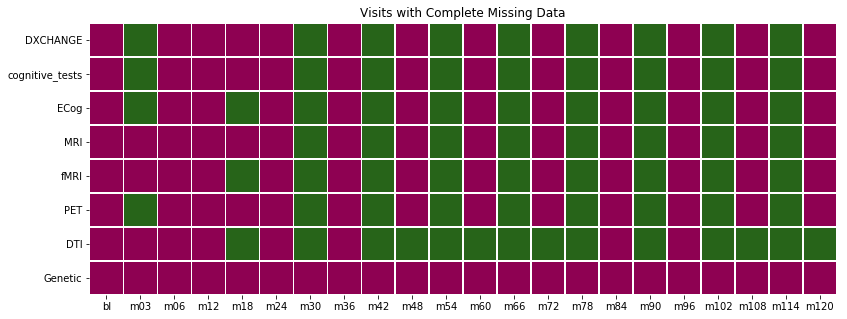

In [48]:
# dataframe to store visits with no measurement
no_data_df = pd.DataFrame(data=0, index=list(no_data_dict.keys()), columns=visit_type)

# populate dataframe with 1 where no measures at a visit
for k,v in no_data_dict.items():
    for visit in v:
        no_data_df.loc[k, visit] = 1
        
# plot
plt.figure(figsize = (16,5))
plt.title('Visits with Complete Missing Data')
sns.heatmap(no_data_df, cmap='PiYG', linewidths=.5, cbar=False, square=True)

Here, we can see that after the third year (m36), the half year visits have no data recorded except for genetic data. Since the genetic data is a constant, let's drop these visit types from the dataframe. We'll reference the MRI values in the no_data_dict because they code the visits we want to drop.

In [49]:
# record shape of the full dataframe
original_df = df.shape

In [50]:
# drop rows with visit codes where there is no data
df.drop(df[df.VISCODE.isin(no_data_dict['MRI'])].index, inplace=True)

In [51]:
# record shape of new dataframe
new_df = df.shape
# display change
print(f'Removing the uninformative visit types dropped {original_df[0] - new_df[0]} rows.')

Removing the uninformative visit types dropped 1824 rows.


## 2.10 Removing NaN Rows

During our inspection of the missing values, we identified some measures of interest that had very low amounts of missing data at baseline. Let's remove these participants now.

In [52]:
# display measures where we drop NaN rows from
print(remove_nan)

['ADAS13_bl', 'APOE4']


In [53]:
# list to store RID (patient identifier)
rid = []

# get RID for rows with missing genetic data
for p in df.loc[df.APOE4.isna(), 'RID']:
    rid.append(p)

# get RID for baseline rows with missing ADAS13 scores
for p in df.loc[(df.ADAS13_bl.isna()) & (df.VISCODE == 'bl'), 'RID']:
    rid.append(p)

# display results
print(f'There are a total of {len(rid)} patients to remove.')

There are a total of 26 patients to remove.


In [54]:
df.shape

(10977, 61)

In [55]:
# drop rows with identified RID values
df.drop(df[df.RID.isin(rid)].index, inplace=True)

In [56]:
df.shape

(10898, 61)

## 2.10 Dealing with Diagnostic Change

One of the most important variables in the dataset is diagnostic change. It will be the outcome variable of our model, as we are attempting to forcast people that convert from healthy or mildly impaired to having a diagnosis of AD. We saw previously that there was a fair amount of missing data in this variable, so let's revisit this now that we've reduced the dataset by removing uninformative visits.

In [57]:
print(df.VISCODE[df.DXCHANGE.isna()].value_counts())
# display total
print(f'There are a total of {df.DXCHANGE.isna().sum()} missing diagnostic change values.')

m18     958
m03     804
m48      45
m36      39
m60      35
m24      32
m72      25
m96      22
m108     21
m84      19
m120     10
m12       7
m06       2
bl        1
Name: VISCODE, dtype: int64
There are a total of 2020 missing diagnostic change values.


We know from the heatmap above that there were no diagnostic changes reported for the month 3 visit, but that there were for the month 18 visit. We can also see that there is a single baseline measurement missing data.

First, let's check that baseline data point. We may be able to fill it in based on the next recorded value for that patient.

Second, the month 3 the values will be filled with the baseline values since these were not recorded for any patient.

Third, we'll look at imputing the missing data for the other visits. If there are no diagnostic changes between the preceding and subsequent diagnostic change values across visits for a patient, it is safe to assume that the missing value can be imputed as there was no change.

In [58]:
# dispaly diagnostic change codes
vector_dict.dx_change_ids

{1: 'Stable:NL to NL',
 2: 'Stable:MCI to MCI',
 3: 'Stable:AD to AD',
 4: 'Conv:NL to MCI',
 5: 'Conv:MCI to AD',
 6: 'Conv:NL to AD',
 7: 'Rev:MCI to NL',
 8: 'Rev:AD to MCI',
 9: 'Rev:AD to NL',
 -1: 'Not available'}

In [59]:
df[df.RID == df.loc[(df.DXCHANGE.isna()) & (df.VISCODE == 'bl'), 'RID'].item()]

,RID,VISCODE,D1,D2,DX_bl,DXCHANGE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,APOE4,ADMNRV,PDMNRV,DMNRVR
11727,4264,bl,0,1,CN,NaN,74.1,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.41406,0.43485,0.95218


We can see that this patient is cognitively normal (CN). We will fill the diagnostic change value of 1 to indicate that the individual is healthy and stable.

In [60]:
# set new diagnostic change value
df.loc[df.RID == 4264, 'DXCHANGE'] = 1

Next, let's clean up the visit code column by converting it to an integer and sorting the dataframe, then sort and reindex the dataframe.

In [61]:
# remove m prefix from visit code
df.VISCODE = df.VISCODE.str.replace('m', '')
# replace bl code with 0
df.VISCODE = df.VISCODE.str.replace('bl', '0')
# change data type to int
df.VISCODE = df.VISCODE.astype('int')
# sort dataframe based on patient ID and visit codes
df.sort_values(by=['RID', 'VISCODE'], inplace=True)
# reset index now that the dataframe is sorted
df.reset_index(drop=True, inplace=True)

Now, convert diagnostic change into a consistent datatype.

In [62]:
df.DXCHANGE = pd.to_numeric(df.DXCHANGE, errors='coerce')

From the value counts output above, we can see that there are 804 missing values at the three month visit. Let's calculate the number of other missing values before filling them.

In [63]:
df.DXCHANGE.isna().sum() - df.DXCHANGE[df.VISCODE == 3].isna().sum()

1215

Now, let's fill in the month 3 diagnostic change values using the baseline values and fill any other missing values if there is no change in diagnosis between visits the preceding and subsequent visits.

In [64]:
for i,r in df.iterrows():
    # fill in month 3 with baseline diagnosis
    if r.VISCODE == 3:
        df.iloc[i,5] = df.iloc[i-1,5]
    # check diagnostic change for NaN and whether the visit before and after has the same code
    # note that this checks to make sure the RID is consistant to ensure we're filling based on
    # a single patient
    elif pd.isna(df.iloc[i,5]) and df.iloc[i-1,5] == df.iloc[i+1,5] and df.iloc[i-1,0] == df.iloc[i+1,0]:
        # fill in value if consistent codes
        df.iloc[i,5] = df.iloc[i-1,5]

In [65]:
df.DXCHANGE.isna().sum()

444

We've reduced the number of missing values by almost 1600. Because diagnostic change will be used as the target variable in our models, it would be nice to keep these 444 data points. However, it doesn't make sense to impute them because the variable is categorical and we can't be sure whether there was an actual change in diagnosis that was not recorded. As such, we'll drop these cases.

In [66]:
df = df[df.DXCHANGE.isna() == False]

In [67]:
print(f'After cleaning up the dataset, there are a total of {df.shape[0]} cases between {len(df.RID.unique())} patients.')

After cleaning up the dataset, there are a total of 10454 cases between 1713 patients.


In [68]:
# make headers lower case
df.columns = map(str.lower, df.columns)
# reset index
df.reset_index(drop=True, inplace=True)

###  2.11 Diagnostic change data cleaning

First, we need to explore the dataset to ensure that we have reliable data for the diagnostic change values. As we've already dealt with missing values, we need to inspect the patients that convert and ensure that their diagnostic change timeline makes sense.

In [69]:
for k,v in vector_dict.dx_change_ids.items():
    print(f'Value {k} represents {v}')

Value 1 represents Stable:NL to NL
Value 2 represents Stable:MCI to MCI
Value 3 represents Stable:AD to AD
Value 4 represents Conv:NL to MCI
Value 5 represents Conv:MCI to AD
Value 6 represents Conv:NL to AD
Value 7 represents Rev:MCI to NL
Value 8 represents Rev:AD to MCI
Value 9 represents Rev:AD to NL
Value -1 represents Not available


The two values that we're interested in are 5, the conversion from MCI to AD, and 6, the conversion of cognitively normal to AD. Let's explore some of the characteristics in the dataset associated with these two diagnostic changes.

In [70]:
# list for patient IDs of converts
converts = []
for i,r in df.iterrows():
    if r.dxchange == 5 or r.dxchange == 6:
        converts.append(r.rid)
# display how many patients convert
print(len(converts))

373


In [71]:
# extract baseline info of patients that convert
dx_bl_df = df[(df.viscode == 0) & (df.rid.isin(converts))]

In [72]:
dx_bl_df.shape

(345, 61)

There is a mismatch between the patient IDs that converted and those extracted from the baseline dataframe. Let's check why this might be.

In [73]:
print(f'There are a total of {len(set(converts))} unique patient IDs.')

There are a total of 340 unique patient IDs.


In [74]:
# list to contain non-duplicate patient IDs
converts_u = []
# set to contain patient IDs with more than one occurance
converts_multi = set()
# loop through patient IDs
for patient in converts:
    # add patient ID if not a duplicate
    if patient not in converts_u and patient not in converts_multi:
        converts_u.append(patient)
    # add duplicates
    else:
        converts_multi.add(patient)
        try:
            converts_u.remove(patient)
        except:
            pass

In [75]:
print(f'There are a total of {len(converts_u)} patients that convert only once and {len(converts_multi)} patients with multiple conversions.')

There are a total of 311 patients that convert only once and 29 patients with multiple conversions.


Although possible, it is unlikely that people are converting in and out of AD. Let's inspect these patients closer and see if we can figure out what might be going on.

In [76]:
dx_multi = df[df.rid.isin(converts_multi)]

In [77]:
dx_multi.dxchange.value_counts()

2.0    104
5.0     62
3.0     37
1.0     22
4.0      2
8.0      1
Name: dxchange, dtype: int64

There is only one instance of a patient converting from AD to CN/MCI (value = 8). There are also no occurances of a CN patient converting to AD (value = 6).

In [78]:
dx_multi.head(20)

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
272,61,0,1,1,CN,1.0,77,Female,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
273,61,6,1,1,CN,1.0,77,Female,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
274,61,12,1,1,CN,1.0,77,Female,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
275,61,18,1,1,CN,1.0,77,Female,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
276,61,24,1,1,CN,1.0,77,Female,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
277,61,36,1,1,CN,1.0,77,Female,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
278,61,48,1,1,CN,1.0,77,Female,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
279,61,60,1,1,CN,1.0,77,Female,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
280,61,72,1,1,CN,1.0,77,Female,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
281,61,84,1,1,CN,4.0,77,Female,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


Looking at patient 61 and 101, it seems like when a patient converts, this conversion is recorded at multiple visits. Let's fix this by checking if the patient has two or more repeated occurances of conversion to AD.

In [79]:
# list to store index values of visits that have repeated conversion diagnostic changes
dx_multi_index = []
for i,r in dx_multi.iterrows():
    # skip first row
    if i == 281:
        pass
    # check to see if current and previous diagnostic change are 5
    elif dx_multi.loc[i, 'dxchange'] == 5 and dx_multi.loc[i-1, 'dxchange'] == 5:
        # check to see if same patient
        if dx_multi.loc[i, 'rid'] == dx_multi.loc[i-1, 'rid']:
            # record index of visit
            dx_multi_index.append(i)

In [80]:
# recode dxchange 5 to 3 for repeated entries
for i in dx_multi_index:
    df.iloc[i, 5] = 3

Now let's check to see that we've cleaned the dataset properly and have no patients with repeating conversions to AD.

In [81]:
# list for patient IDs of converts
converts = []
for i,r in df.iterrows():
    if r.dxchange == 5 or r.dxchange == 6:
        converts.append(r.rid)
# display how many patients convert
print(len(converts))

351


In [82]:
len(set(converts))

340

There are still problems with 11 patients. Let's pull the patient IDs for these and look at them.

In [83]:
# list to contain non-duplicate patient IDs
converts_u = []
# set to contain patient IDs with more than one occurance
converts_multi = set()
# loop through patient IDs
for patient in converts:
    # add patient ID if not a duplicate
    if patient not in converts_u and patient not in converts_multi:
        converts_u.append(patient)
    # add duplicates
    else:
        converts_multi.add(patient)
        try:
            converts_u.remove(patient)
        except:
            pass

In [84]:
df[df.rid.isin(converts_multi)]

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
767,166,0,1,1,CN,1.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
768,166,6,1,1,CN,1.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
769,166,12,1,1,CN,1.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
770,166,18,1,1,CN,1.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
771,166,24,1,1,CN,1.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
772,166,36,1,1,CN,1.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
773,166,60,1,1,CN,5.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
774,166,72,1,1,CN,2.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
775,166,84,1,1,CN,5.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
776,166,96,1,1,CN,3.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


It appears that in some cases, such as patient 166, that there is a conversion to MCI that is coded as a conversion to AD. This is evident because they enter the study as CN, convert to AD but remain stable as MCI, then later convert again to AD. In other cases, such as patient 4947, there appear to be wrong entries (index 9750) in the dxchange column. Because the patients who convert to AD are critical to our model, we'll go through each of these and fix them one by one.

In [85]:
# change set to list
converts_multi = list(converts_multi)
# display first patient
df[df.rid == converts_multi[0]]

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
7894,4414,0,1,1,LMCI,2.0,60.8,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
7895,4414,6,1,1,LMCI,5.0,60.8,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
7896,4414,12,1,1,LMCI,3.0,60.8,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
7897,4414,24,1,1,LMCI,5.0,60.8,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
7898,4414,36,1,1,LMCI,3.0,60.8,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
7899,4414,48,1,1,LMCI,3.0,60.8,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [86]:
# AD stable
df.loc[7897, 'dxchange'] = 3

In [87]:
# display next patient
df[df.rid == converts_multi[1]]

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
8409,4542,0,1,1,LMCI,2.0,79.3,Female,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.83879,0.66878,1.25420
8410,4542,3,1,1,LMCI,2.0,79.3,Female,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.61526,0.88235,0.69729
8411,4542,6,1,1,LMCI,5.0,79.3,Female,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.62512,0.66809,0.93569
8412,4542,12,1,1,LMCI,3.0,79.3,Female,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.86926,0.72541,1.19830
8413,4542,24,1,1,LMCI,5.0,79.3,Female,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.73930,0.68384,1.08110
8414,4542,36,1,1,LMCI,3.0,79.3,Female,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN


In [88]:
# AD stable
df.loc[8413, 'dxchange'] = 3

In [89]:
# display next patient
df[df.rid == converts_multi[2]]

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
7390,4293,0,1,1,LMCI,2.0,69.7,Male,12,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.56881,0.65893,0.86323
7391,4293,3,1,1,LMCI,2.0,69.7,Male,12,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.63867,0.64890,0.98423
7392,4293,6,1,1,LMCI,2.0,69.7,Male,12,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.56812,0.62121,0.91454
7393,4293,12,1,1,LMCI,2.0,69.7,Male,12,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.67492,0.58268,1.15830
7394,4293,24,1,1,LMCI,5.0,69.7,Male,12,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.61420,0.58311,1.05330
7395,4293,36,1,1,LMCI,2.0,69.7,Male,12,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7396,4293,48,1,1,LMCI,5.0,69.7,Male,12,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.84043,0.58839,1.42840


In [90]:
# MCI stable
df.loc[7394, 'dxchange'] = 2

In [91]:
# display next patient
df[df.rid == converts_multi[3]]

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
767,166,0,1,1,CN,1.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
768,166,6,1,1,CN,1.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
769,166,12,1,1,CN,1.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
770,166,18,1,1,CN,1.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
771,166,24,1,1,CN,1.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
772,166,36,1,1,CN,1.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
773,166,60,1,1,CN,5.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
774,166,72,1,1,CN,2.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
775,166,84,1,1,CN,5.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
776,166,96,1,1,CN,3.0,72.5,Female,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [92]:
# convert to MCI
df.loc[773, 'dxchange'] = 4

In [93]:
# display next patient
df[df.rid == converts_multi[4]]

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
9106,4741,0,1,1,LMCI,2.0,61.6,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
9107,4741,3,1,1,LMCI,2.0,61.6,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
9108,4741,6,1,1,LMCI,5.0,61.6,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
9109,4741,12,1,1,LMCI,2.0,61.6,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
9110,4741,24,1,1,LMCI,5.0,61.6,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
9111,4741,36,1,1,LMCI,3.0,61.6,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
9112,4741,48,1,1,LMCI,3.0,61.6,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [94]:
# MCI stable
df.loc[9108, 'dxchange'] = 2

In [95]:
# display next patient
df[df.rid == converts_multi[5]]

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
4171,1097,0,1,0,LMCI,2.0,73,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4172,1097,6,1,0,LMCI,2.0,73,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4173,1097,12,1,0,LMCI,2.0,73,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4174,1097,18,1,0,LMCI,2.0,73,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4175,1097,24,1,0,LMCI,2.0,73,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4176,1097,36,1,0,LMCI,2.0,73,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4177,1097,48,1,0,LMCI,5.0,73,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4178,1097,60,1,0,LMCI,3.0,73,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
4179,1097,72,1,0,LMCI,5.0,73,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [96]:
# AD stable
df.loc[4179, 'dxchange'] = 3

In [97]:
# display next patient
df[df.rid == converts_multi[6]]

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
7971,4430,0,1,1,LMCI,2.0,80,Male,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7972,4430,3,1,1,LMCI,2.0,80,Male,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7973,4430,6,1,1,LMCI,5.0,80,Male,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7974,4430,12,1,1,LMCI,2.0,80,Male,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7975,4430,24,1,1,LMCI,3.0,80,Male,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7976,4430,36,1,1,LMCI,5.0,80,Male,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
7977,4430,48,1,1,LMCI,3.0,80,Male,15,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


This patient is more complicated. It could be that they either are stable MCI at month 6 or convert to AD and have month 12 and 24 recorded wrong. In this case the patient will be dropped.

In [98]:
patients_to_drop = [4430]

In [99]:
# display next patient
df[df.rid == converts_multi[7]]

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
5140,1394,0,1,0,LMCI,2.0,77.1,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
5141,1394,6,1,0,LMCI,2.0,77.1,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
5142,1394,12,1,0,LMCI,5.0,77.1,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
5143,1394,18,1,0,LMCI,3.0,77.1,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
5144,1394,24,1,0,LMCI,5.0,77.1,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
5145,1394,36,1,0,LMCI,3.0,77.1,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
5146,1394,48,1,0,LMCI,3.0,77.1,Male,18,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [100]:
# stable AD
df.loc[5144, 'dxchange'] = 3

In [101]:
# display next patient
df[df.rid == converts_multi[8]]

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
9748,4947,0,1,0,EMCI,2.0,74.5,Male,14,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.59061,0.55416,1.06580
9749,4947,3,1,0,EMCI,2.0,74.5,Male,14,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.71663,0.66484,1.07790
9750,4947,6,1,0,EMCI,5.0,74.5,Male,14,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.57304,0.60773,0.94292
9751,4947,12,1,0,EMCI,2.0,74.5,Male,14,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.64834,0.69708,0.93009
9752,4947,24,1,0,EMCI,5.0,74.5,Male,14,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.59951,0.63133,0.94959


In [102]:
# MCI stable
df.loc[9750, 'dxchange'] = 2

In [103]:
# display next patient
df[df.rid == converts_multi[9]]

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
2276,566,0,1,1,LMCI,2.0,78.8,Male,20,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2277,566,6,1,1,LMCI,2.0,78.8,Male,20,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2278,566,12,1,1,LMCI,2.0,78.8,Male,20,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2279,566,18,1,1,LMCI,2.0,78.8,Male,20,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2280,566,24,1,1,LMCI,2.0,78.8,Male,20,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2281,566,36,1,1,LMCI,5.0,78.8,Male,20,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2282,566,60,1,1,LMCI,2.0,78.8,Male,20,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2283,566,72,1,1,LMCI,5.0,78.8,Male,20,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2284,566,84,1,1,LMCI,3.0,78.8,Male,20,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2285,566,96,1,1,LMCI,3.0,78.8,Male,20,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [104]:
# MCI stable
df.loc[2281, 'dxchange'] = 2

In [105]:
# display next patient
df[df.rid == converts_multi[10]]

,rid,viscode,d1,d2,dx_bl,dxchange,age,ptgender,pteducat,ptethcat,...,av1451_entorhinal_l,av1451_entorhinal_r,fa_hippocampus_l,fa_hippocampus_r,md_hippocampus_l,md_hippocampus_r,apoe4,admnrv,pdmnrv,dmnrvr
2749,702,0,1,0,LMCI,2.0,85,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2750,702,6,1,0,LMCI,2.0,85,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2751,702,12,1,0,LMCI,2.0,85,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2752,702,18,1,0,LMCI,2.0,85,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2753,702,24,1,0,LMCI,5.0,85,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2754,702,36,1,0,LMCI,8.0,85,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2755,702,48,1,0,LMCI,5.0,85,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2756,702,60,1,0,LMCI,3.0,85,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2757,702,72,1,0,LMCI,3.0,85,Male,16,Not Hisp/Latino,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


This patient appears correct and went from AD to MCI and back to AD. We'll leave it as is. Now let's remove the one patient and extract the baseline variables for people that convert to characterize them.

In [106]:
# drop problematic patient from dataframe
df.drop(df[df.rid == patients_to_drop[0]].index, inplace=True)
# drop problematic patient from convert list
converts_multi.remove(patients_to_drop[0])
# intiate final convert list
converts = converts_u + converts_multi

In [107]:
len(converts)

339

In [108]:
# baseline dataframe of patients that convert
dx_df = df[df.rid.isin(converts)]

In [109]:
# extract baseline rows
dx_bl_df = dx_df[dx_df.viscode == 0]

In [110]:
len(dx_bl_df)

344

We can see here that there is still a mismatch between the number of patients that convert and the entries in the dataframe we will analyze. This needs to be cleaned up before we do any further analysis.

In [111]:
dx_bl_df.rid.value_counts()[:5]

4515    3
4250    2
4346    2
4363    2
511     1
Name: rid, dtype: int64

It appears that there are multiple baseline entries for four different patients.

In [112]:
# list to store indexes for visits to remove
visits_to_remove = []
for i,r in df.iterrows():
    try:
        # check to see if duplicate visit code for each patient
        if df.loc[i, 'viscode'] == df.loc[i-1, 'viscode'] and df.loc[i, 'rid'] == df.loc[i-1, 'rid']:
            # record duplicate index
            visits_to_remove.append(i)
    except:
        pass

In [113]:
len(visits_to_remove)

60

In [114]:
# drop duplicate rows
df.drop(df.loc[visits_to_remove].index, inplace=True)

In [115]:
# baseline dataframe of patients that convert
dx_df = df[df.rid.isin(converts)]

In [116]:
# extract baseline rows
dx_bl_df = dx_df[dx_df.viscode == 0]

In [117]:
len(dx_bl_df)

339

Now we have a properly cleaned dataframe that we can do some inspection and analysis on.

In [118]:
# save cleaned dataframe as csv
df.to_csv('df_cleaned.csv')

## 2.11 Summary

The data cleaning here consisted of extracting and renaming columns of interest, merging dataframes, and identifying missing values and how to treat them.


The primary model will consist of demographic, structural MRI, genetic, and cognitive test data. This model will be compared against reduced models that include cases from the full model that also include data points from the categories specific to the reduced model (i.e. DTI, PET, fMRI). The next step is to start exploring the data using visualizations and some preliminary data analysis to pull out as much insight as possible before developing the statistical models.